# Visualization of CO2 Data


Through two steps, this script visualized the fCO2 values on the ocean surface.
1. read the data (the data are cleaned in another script), and select the columns we need
2. draw the base map and plot the data point with different color code (based on the CO2 concentration).

In [1]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget
from matplotlib.cm import ScalarMappable
import seaborn as sns
import matplotlib
from matplotlib.widgets import RangeSlider
from matplotlib.widgets import Button
import boto3
import json

# Read the data

In [ ]:
def read_config(file_path='/efs/user-info/info-all.json'):
    '''
    Open a configur
    '''
    with open(file_path, 'r') as file:
        config = json.load(file)
    return config
    
def read_from_s3(config):
    '''
    read the data from a S3 bucket in AWS Cloud
    '''
    s3_client = boto3.client('s3', aws_access_key_id=config.get('aws_access_key_id'), aws_secret_access_key=config.get('aws_secret_access_key'))
    response = s3_client.get_object(Bucket='databrix-bucket', Key='CO2data.csv')
    data = response["Body"]
    return data

config = read_config()
data = read_from_s3(config)

In [2]:
#load data into a pandas Dataframe
df = pd.read_csv(data)

# convert the range of longitude from [0,360] to [-180,180]
df.loc[df['longitude [dec.deg.E]']> 180,'longitude [dec.deg.E]'] = df.loc[df['longitude [dec.deg.E]']> 180,'longitude [dec.deg.E]'] -360

C:\Users\wiw\AppData\Local\Temp\ipykernel_7052\400594164.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CO2data.csv")


# Plot data

In [3]:
def plot_base_map():
    '''
    plot a base map on the figure
    '''
    global m
    
    # draw the base map
    m=Basemap(projection='mill', llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')
    # m.bluemarble()
    m.drawcoastlines()
    m.fillcontinents()
    m.drawparallels(np.arange(-90.,90.,30.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

def plot_co2(event):
    '''
    plot the co2 concentration on basemap (colors represent different values)
    '''
    global f
    
    # press c for clear the scatter on the basmap
    if event.key == 'c':
        f.remove()
    
    # press enter for draw the next time region
    if event.key == 'enter':
        try:
            f.remove()
        except:
            None


        axes = fig.axes[0]
        
        # slice the dataframe, which contains only selected years
        years = np.arange(slider.val[0], slider.val[1] +1)
        akt_data = df.loc[df.yr.isin(years), :]

        # save the data point in a list like object.
        fco2_whole = df['fCO2rec [uatm]'].values
        lat  = akt_data['latitude [dec.deg.N]'].values
        lon  = akt_data['longitude [dec.deg.E]'].values
        fco2 = akt_data['fCO2rec [uatm]'].values


        # convert longitude and latitude to the coordinate, which basemap knows.                                                  
        x, y = m(lon,lat)

        #draw the data points with different colors
        f = axes.scatter(x,y,
                      s = 0.0001, # size of the point
                      c = fco2 ,  # the color of co2 concentration of each points
                      cmap = 'jet', # the colors used in colorbar
                      norm = 'linear', # use a liear normalization for the values of co2 concentration

                      # Because the values concentrate in small range,
                      # so, we use a smaller range to normalize the values
                      # otherwise, we only see one color
                      vmin=np.quantile(fco2_whole,0.1), # min value used in normalization
                      vmax=np.quantile(fco2_whole,0.9)) # max value used in normalization

        # draw the color bar.
        try:
            a = fig.axes[2]
        except:
            cb = plt.colorbar( f, label = 'fCO2rec [uatm]')

        plt.show()
    
    
def plot_slide():
    '''
    plot a slider to select wanted time region to plot
    '''
    global slider
    slider_ax = fig.add_axes([0.15, 0.02, 0.7, 0.03])
    slider = RangeSlider(slider_ax, "Years", 1957, 2023,valinit = (2022,2023) ,valstep = 1)
    fig.subplots_adjust(bottom=0.1)

<IPython.core.display.Javascript object>


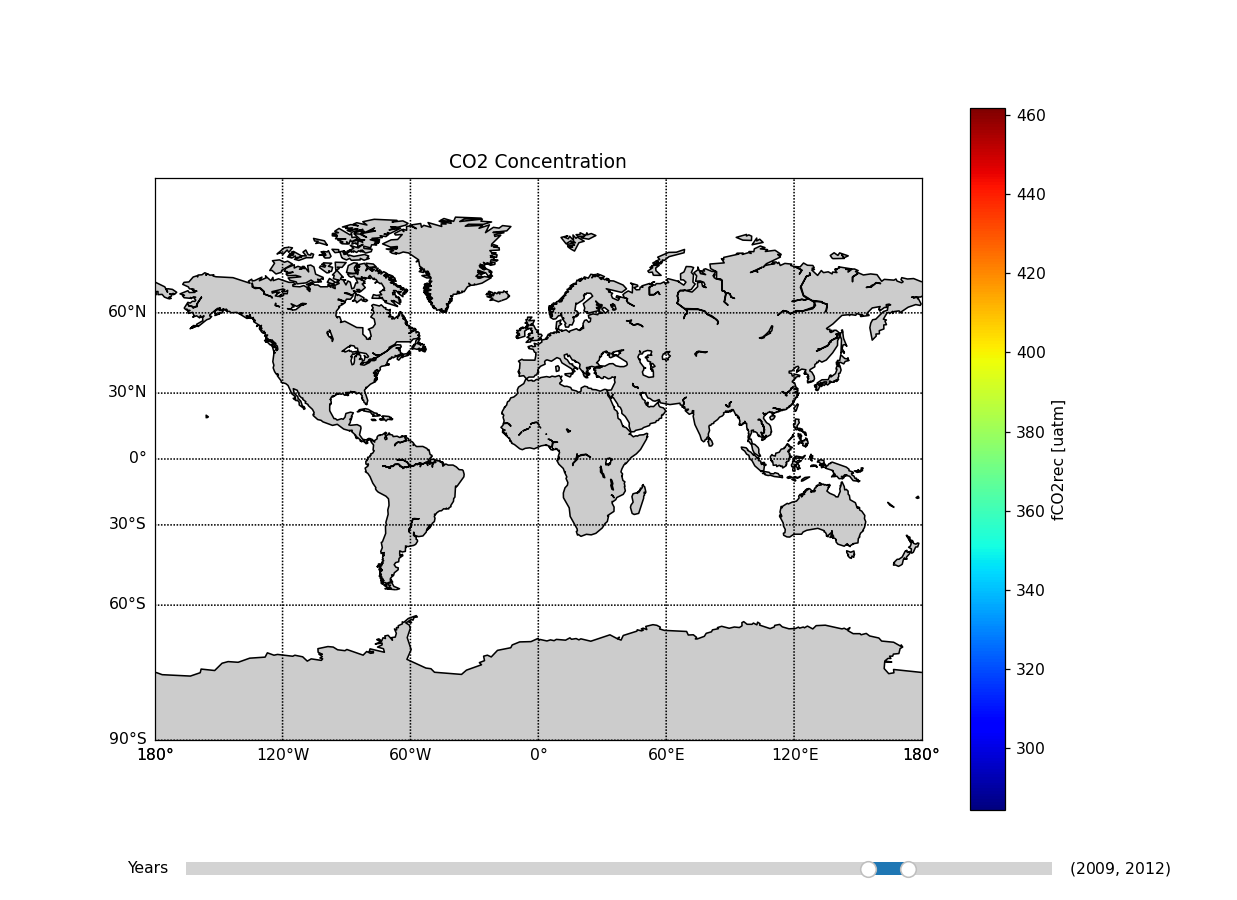

In [4]:
# creat a figure
fig=plt.figure(figsize=(11, 8))
# set a title of the figure
plt.title('CO2 Concentration')
# plot the whole world
plot_base_map()
# plot a slider, slide the slider to select a time region.
plot_slide()
# press enter to plot, and press c to clear the scatter points
cid = fig.canvas.mpl_connect('key_press_event',plot_co2)

## Plot the changes over time

<IPython.core.display.Javascript object>


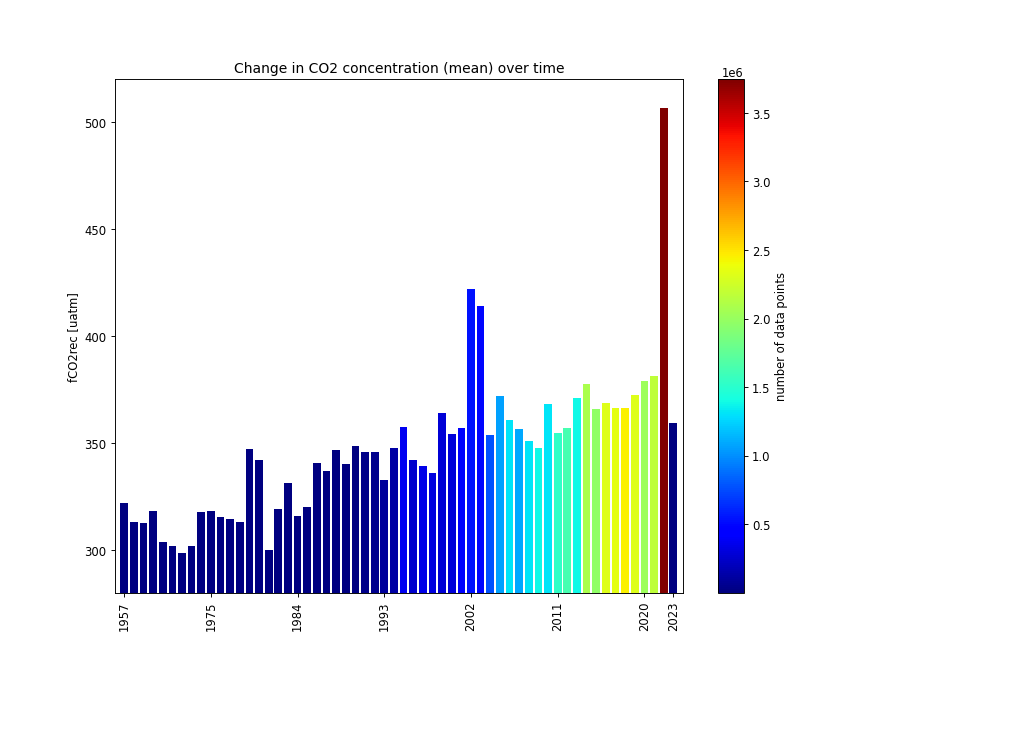

In [150]:
data_bar = df.groupby(by = 'yr').agg({'fCO2rec [uatm]': 'mean', 'mon': 'count'}).reset_index()

ax = plt.figure(figsize=(11, 8))

cm = matplotlib.cm.ScalarMappable(norm='linear', cmap='jet')
colors = cm.to_rgba(data_bar.mon.values)

x_years = np.arange(0,len(data_bar.yr))
plt.bar(x_years , data_bar["fCO2rec [uatm]"],color = colors)
plt.xlim(-1,58)
plt.ylim(280,520)
plt.xticks([0,9,18,27,36,45,54,57])
plt.ylabel('fCO2rec [uatm]')
plt.title('Change in CO2 concentration (mean) over time')
ax.axes[0].set_xticklabels(data_bar.yr.values[[0,9,18,27,36,45,54,57]], rotation = 'vertical')
plt.colorbar(cm, ax = ax.axes[0], label= 'number of data points')

## Correlation Matrix

<IPython.core.display.Javascript object>


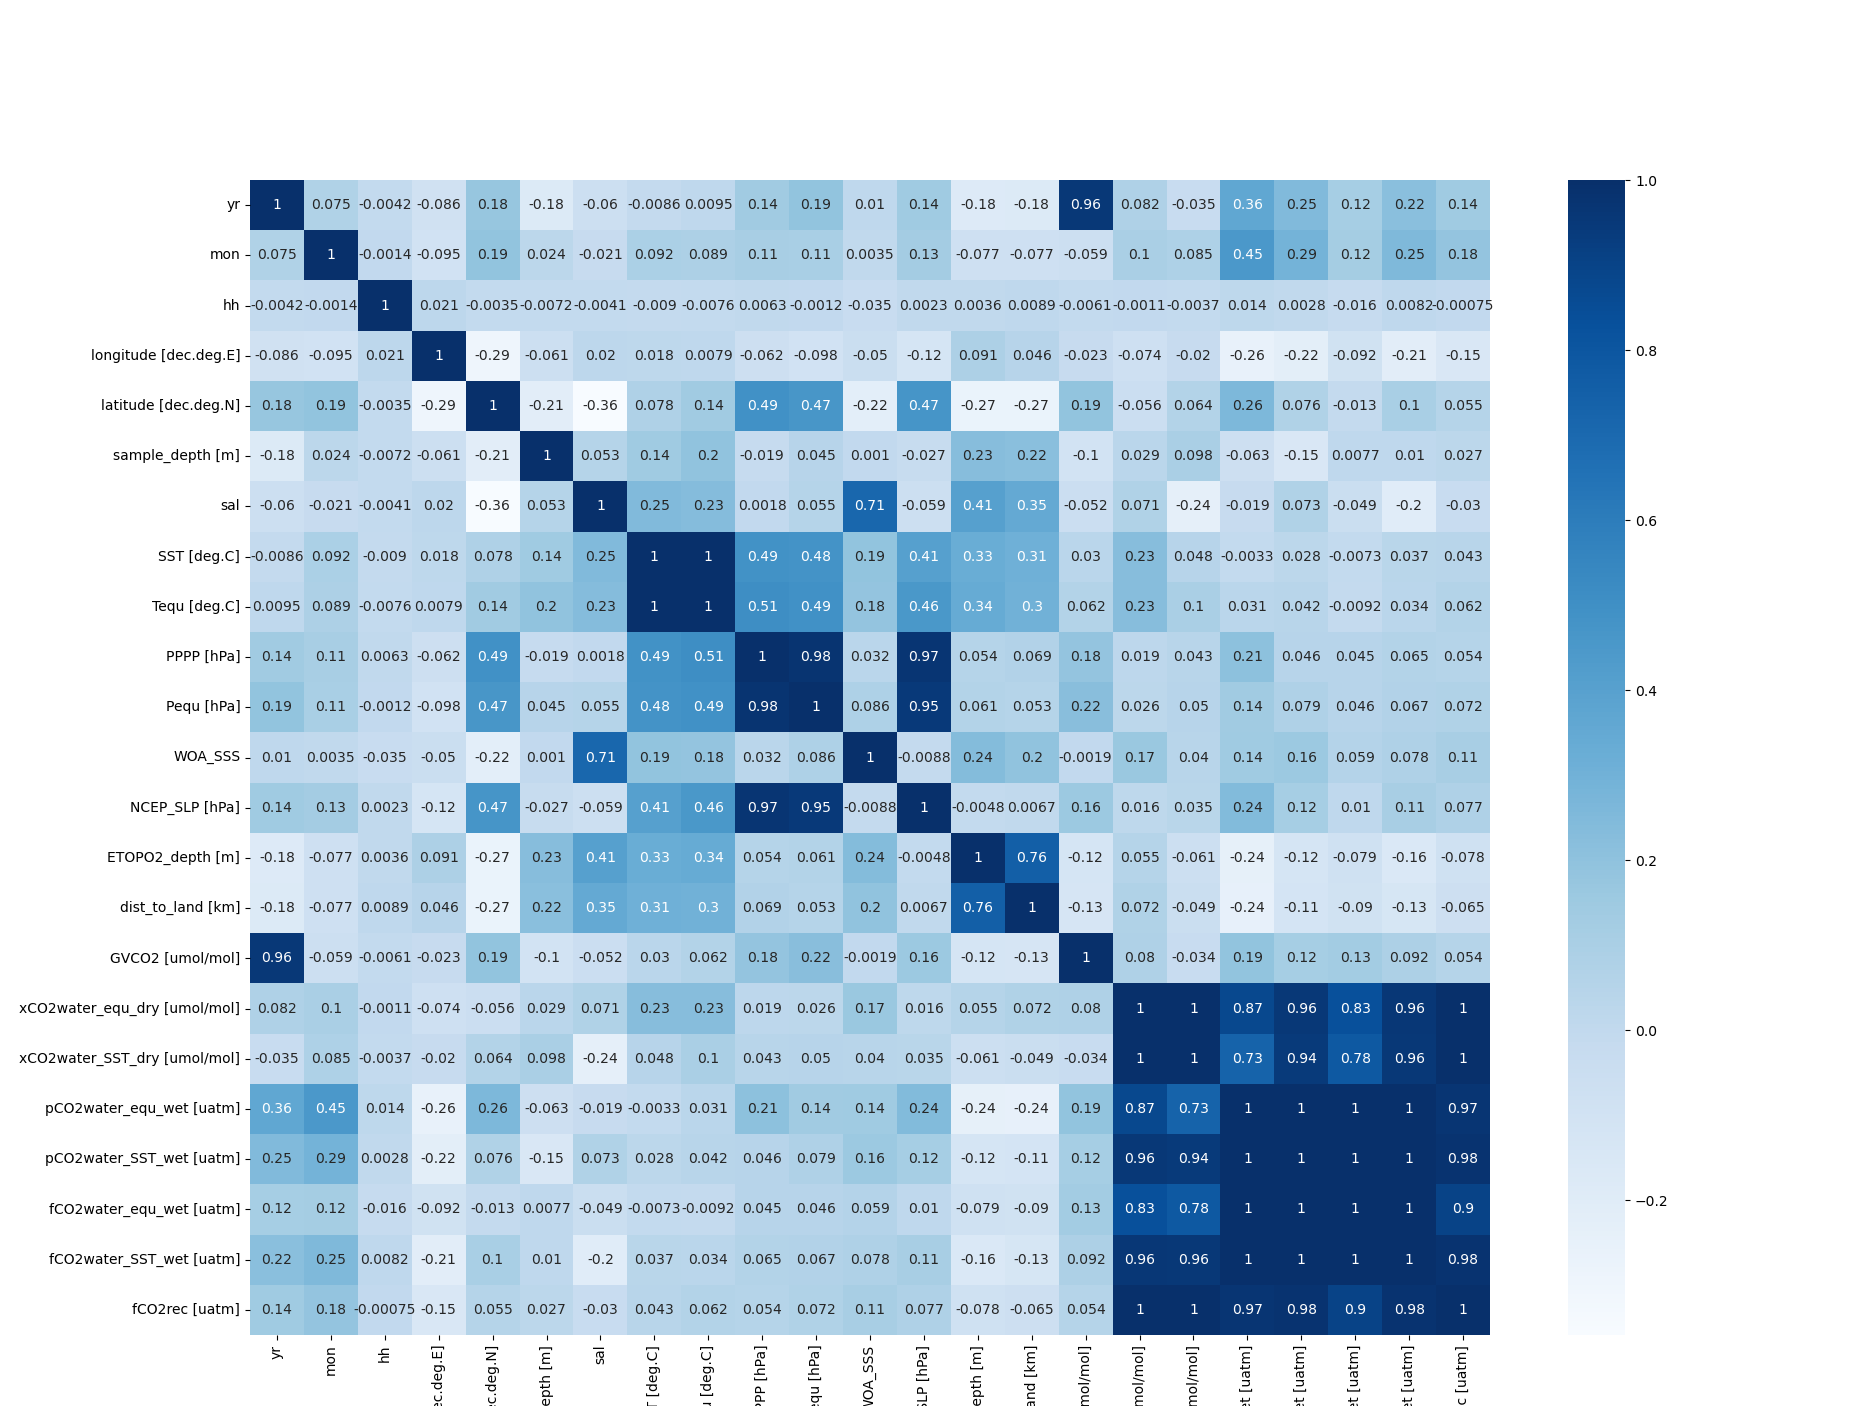

<Axes: >

In [140]:
plt.figure(figsize=(20, 15))
corr = df.iloc[:,[5,6,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]].corr(numeric_only = True)
sns.heatmap(corr, cmap="Blues", annot=True)

<IPython.core.display.Javascript object>


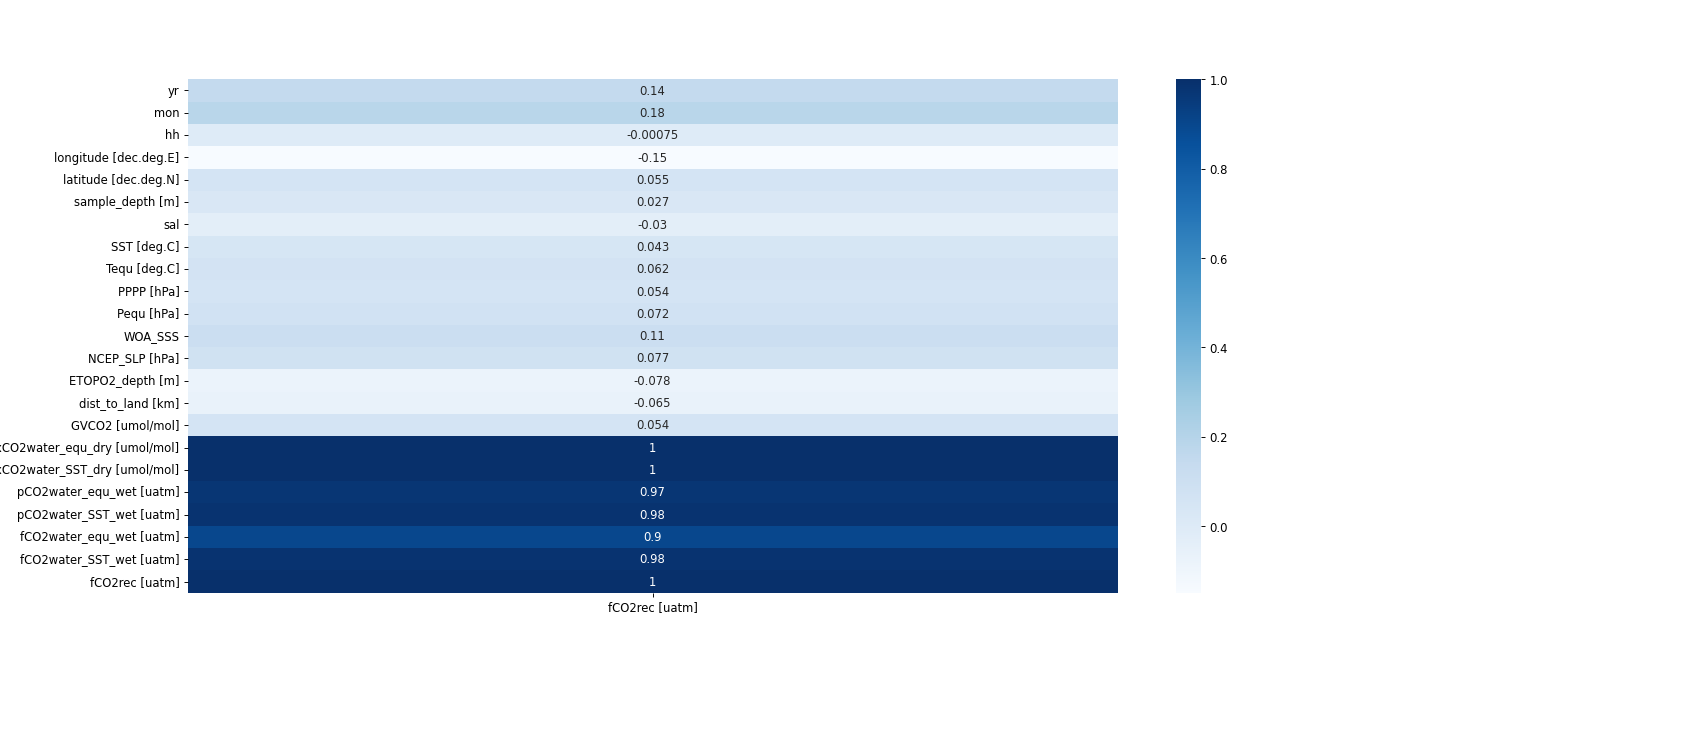

<Axes: >

In [149]:
plt.figure(figsize=(18, 8))
corr = df.iloc[:,[5,6,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]].corr(numeric_only = True)
sns.heatmap(pd.DataFrame(corr.loc['fCO2rec [uatm]',:]), cmap="Blues", annot=True)